Import all required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
def plot_confusion_matrix_with_green_diagonal(y_true, y_pred, labels, title, figsize=(8, 6)):
    """
    Plot confusion matrix with correct predictions (diagonal) highlighted in varying shades of green
    based on the frequency of correct predictions
    """
    from matplotlib.colors import ListedColormap
    import matplotlib.colors as mcolors
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create a normalized confusion matrix for better color scaling
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create base heatmap with purple colormap for incorrect predictions
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Purples', alpha=0.8)
    
    # Get diagonal values for green intensity scaling
    diagonal_values = np.diag(cm)
    max_diagonal = max(diagonal_values) if len(diagonal_values) > 0 else 1
    min_diagonal = min(diagonal_values) if len(diagonal_values) > 0 else 0
    
    # Highlight diagonal (correct predictions) in varying shades of green
    for i in range(len(labels)):
        # Calculate green intensity based on frequency
        frequency = diagonal_values[i]
        if max_diagonal > min_diagonal:
            # Normalize frequency to range 0.3-0.9 for better visibility
            intensity = 0.3 + 0.6 * (frequency - min_diagonal) / (max_diagonal - min_diagonal)
        else:
            intensity = 0.6  # Default intensity if all values are the same
        
        # Create green color with varying intensity
        green_color = mcolors.to_rgba('green', alpha=intensity)
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, 
                                  fill=True, color=green_color))
    
    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm.shape):
        color = 'black' if i == j else ('white' if cm_normalized[i, j] > thresh else 'black')
        ax.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center", 
                verticalalignment="center",
                color=color, fontweight='bold' if i == j else 'normal')
    
    # Set labels and title
    ax.set_xlabel('Predicted Quality')
    ax.set_ylabel('True Quality')
    ax.set_title(title)
    
    # Set tick marks
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    
    plt.tight_layout()
    plt.show()
    
    return cm

Lets first import the data. We will look at both red and white wine seperately.

## Data Quality Check
Let's first examine the data to understand the quality distributions and check for any anomalies.

In [ ]:
# Load datasets
df_red = pd.read_csv("Data/Raw/Wine_Datasets/UCI_Wines/winequality-red.csv", sep=';')
df_white = pd.read_csv("Data/Raw/Wine_Datasets/UCI_Wines/winequality-white.csv", sep=';')

# Prepare datasets in a dictionary for easy looping
datasets = {
    "Red Wine": df_red,
    "White Wine": df_white
}
df_merged = pd.concat([df_red, df_white], ignore_index=True)

# Variables with high VIFs identified from previous analysis
high_vifs = ['fixed acidity', 'density', 'residual sugar', 'is_red_wine', 'alcohol']

In [5]:
# Check the quality distributions and data integrity
for name, df in [("Red Wine", df_red), ("White Wine", df_white)]:
    print(f"\n=== {name} Dataset ===")
    print(f"Shape: {df.shape}")
    print(f"Quality column type: {df['quality'].dtype}")
    print(f"Quality value counts:")
    print(df['quality'].value_counts().sort_index())
    print(f"Quality range: {df['quality'].min()} to {df['quality'].max()}")
    
    # Check for any non-integer values or outliers
    print(f"Unique quality values: {sorted(df['quality'].unique())}")
    
    # Check for missing values
    print(f"Missing values in quality: {df['quality'].isnull().sum()}")
    
    # Check data types of all columns
    print(f"Data types:")
    print(df.dtypes)


=== Red Wine Dataset ===
Shape: (1599, 12)
Quality column type: int64
Quality value counts:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64
Quality range: 3 to 8
Unique quality values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Missing values in quality: 0
Data types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

=== White Wine Dataset ===
Shape: (4898, 12)
Quality column type: int64
Quality value counts:
quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64
Quality range: 3 to 9
Unique quality values: [np.int64(3)

Logistic Regression


=== Red Wine - Logistic Regression ===
Target (y) range before split: 3 to 8
Target (y) unique values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
y_train range: 3 to 8
y_test range: 3 to 8
Predictions range: 4 to 7
Unique predictions: [np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Logistic Regression Accuracy (6 classes): 0.575
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

Per-class metrics:
Class 3  Precision: 0.000  Recall: 0.000  F1: 0.000
Class 4  Precision: 1.000  Recall: 0.100  F1: 0.182
Class 5  Precision: 0.632  Recall: 0.754  F1: 0.688
Class 6  Precision: 0.539  Recall: 0.576  F1: 0.557
Class 7  Precision: 0.391  Recall: 0.214  F1: 0.277
Class 8  Precision: 0.000  Recall: 0.000  F1: 0.000


c:\Users\silla\anaconda3\envs\engg2112\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


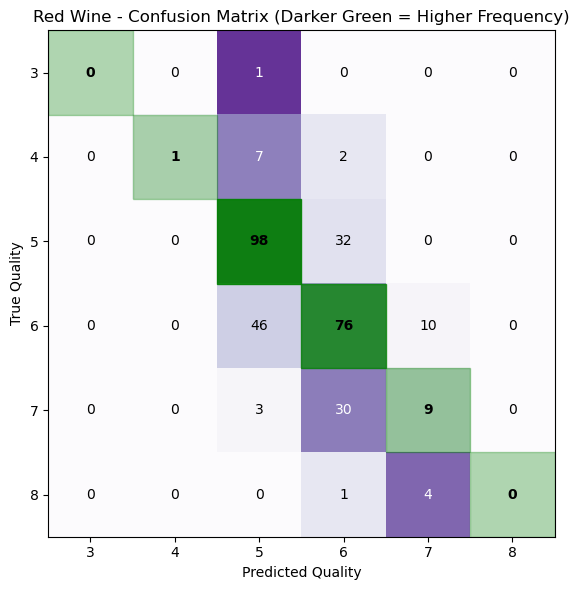


=== White Wine - Logistic Regression ===
Target (y) range before split: 3 to 9
Target (y) unique values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
y_train range: 3 to 9
y_test range: 3 to 8


c:\Users\silla\anaconda3\envs\engg2112\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Predictions range: 4 to 9
Unique predictions: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Invalid predictions: [9]
Logistic Regression Accuracy (6 classes): 0.532
Classes present in test/pred data: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Per-class metrics:
Class 3  Precision: 0.000  Recall: 0.000  F1: 0.000
Class 4  Precision: 0.500  Recall: 0.040  F1: 0.074
Class 5  Precision: 0.581  Recall: 0.519  F1: 0.548
Class 6  Precision: 0.511  Recall: 0.748  F1: 0.607
Class 7  Precision: 0.554  Recall: 0.240  F1: 0.335
Class 8  Precision: 0.000  Recall: 0.000  F1: 0.000
Class 9  Precision: 0.000  Recall: 0.000  F1: 0.000


C:\Users\silla\AppData\Local\Temp\ipykernel_21688\2850049004.py:70: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


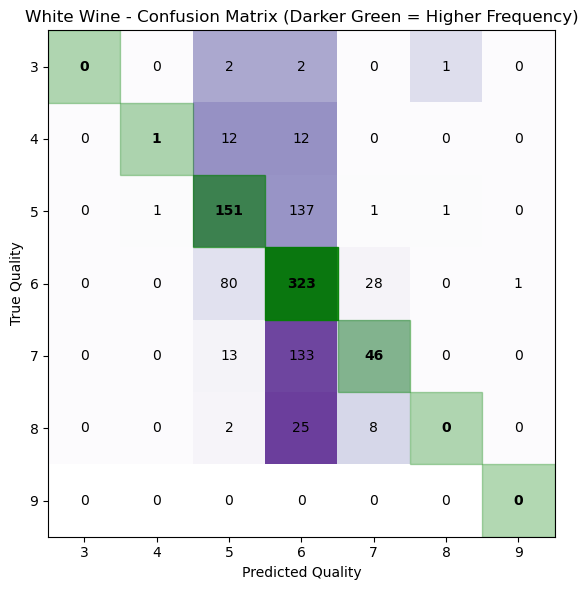

In [ ]:
# Logistic Regression for both datasets
df = df_merged.copy().drop(columns=high_vifs)


print(f"\n=== {name} - Logistic Regression ===")

# Separate features and labels
X = df.drop(["quality"], axis=1)
y = df["quality"]

# Debug: Check y values before splitting
print(f"Target (y) range before split: {y.min()} to {y.max()}")
print(f"Target (y) unique values: {sorted(y.unique())}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Debug: Check splits
print(f"y_train range: {y_train.min()} to {y_train.max()}")
print(f"y_test range: {y_test.min()} to {y_test.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
# Logistic Regression (multinomial)
log_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=42)
log_model.fit(X_train_scaled, y_train)
    
# Predictions
y_pred = log_model.predict(X_test_scaled)

# Debug: Check predictions
print(f"Predictions range: {y_pred.min()} to {y_pred.max()}")
print(f"Unique predictions: {sorted(np.unique(y_pred))}")

# Check if any predictions are outside expected range
invalid_preds = y_pred[(y_pred < 3) | (y_pred > 8)]
if len(invalid_preds) > 0:
    print(f"WARNING: Found {len(invalid_preds)} predictions outside range 3-8!")
    print(f"Invalid predictions: {invalid_preds}")
    
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy (6 classes): {acc:.3f}")

# Get unique classes present in the data for proper labeling
unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"Classes present in test/pred data: {unique_classes}")
    
# Precision, recall and F1 score per class
precisions = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)

print("\nPer-class metrics:")
for cls, p, r, f in zip(unique_classes, precisions, recalls, f1s):
    print(f"Class {cls:1d}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

# Confusion matrix with custom coloring (green diagonal)
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)

# Create custom colormap for highlighting correct predictions
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a normalized confusion matrix for better color scaling
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create base heatmap with purple colormap for incorrect predictions
im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Purples', alpha=0.8)

# Get diagonal values for green intensity scaling
diagonal_values = np.diag(cm)
max_diagonal = max(diagonal_values) if len(diagonal_values) > 0 else 1
min_diagonal = min(diagonal_values) if len(diagonal_values) > 0 else 0

# Highlight diagonal (correct predictions) in varying shades of green
for i in range(len(unique_classes)):
    # Calculate green intensity based on frequency
    frequency = diagonal_values[i]
    if max_diagonal > min_diagonal:
        # Normalize frequency to range 0.3-0.9 for better visibility
        intensity = 0.3 + 0.6 * (frequency - min_diagonal) / (max_diagonal - min_diagonal)
    else:
        intensity = 0.6  # Default intensity if all values are the same
    
    # Create green color with varying intensity
    green_color = mcolors.to_rgba('green', alpha=intensity)
    ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, 
                                fill=True, color=green_color))

# Add text annotations
thresh = cm_normalized.max() / 2.
for i, j in np.ndindex(cm.shape):
    color = 'black' if i == j else ('white' if cm_normalized[i, j] > thresh else 'black')
    ax.text(j, i, format(cm[i, j], 'd'),
            horizontalalignment="center", 
            verticalalignment="center",
            color=color, fontweight='bold' if i == j else 'normal')

# Set labels and title
ax.set_xlabel('Predicted Quality')
ax.set_ylabel('True Quality')
ax.set_title(f'{name} - Confusion Matrix (Darker Green = Higher Frequency)')

# Set tick marks
ax.set_xticks(np.arange(len(unique_classes)))
ax.set_yticks(np.arange(len(unique_classes)))
ax.set_xticklabels(unique_classes)
ax.set_yticklabels(unique_classes)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

plt.tight_layout()
plt.show()

K-Nearest-Neighbour


=== Red Wine ===
KNN Accuracy (k=5): 0.878
low     Precision: 0.000  Recall: 0.000  F1: 0.000
medium  Precision: 0.903  Recall: 0.960  F1: 0.930
high    Precision: 0.645  Recall: 0.426  F1: 0.513


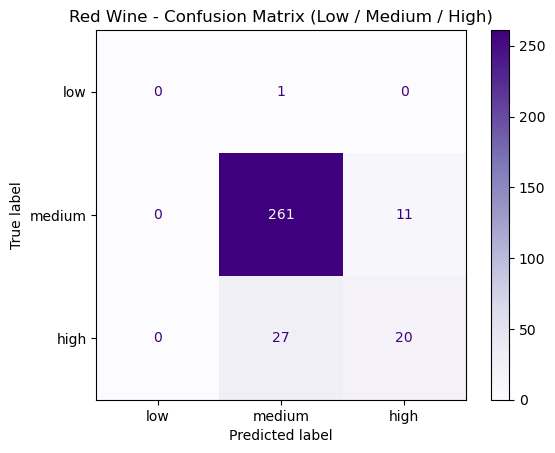


=== White Wine ===
KNN Accuracy (k=5): 0.831
low     Precision: 0.000  Recall: 0.000  F1: 0.000
medium  Precision: 0.863  Recall: 0.925  F1: 0.893
high    Precision: 0.685  Recall: 0.537  F1: 0.602


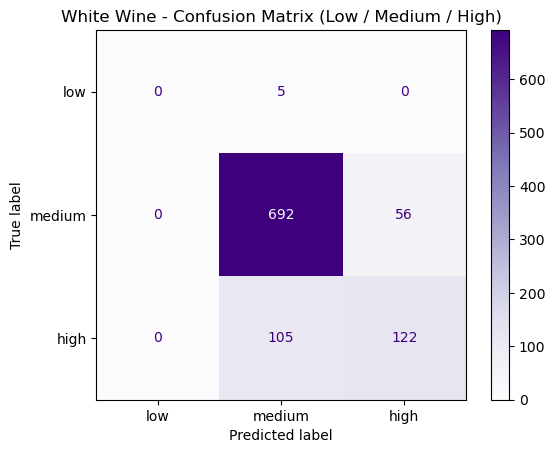

In [6]:
# Set number of neighbors for KNN
k = 5

for name, df in datasets.items():
    print(f"\n=== {name} ===")
    
    # Separate features and labels
    X = df.drop(["quality", "quality_category"], axis=1)
    y = df["quality_category"]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # K-Nearest Neighbors classifier
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = knn_model.predict(X_test_scaled)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"KNN Accuracy (k={k}): {acc:.3f}")

    # Precision, recall and F1 score (balance of the two)
    labels = ["low", "medium", "high"]
    precisions = precision_score(y_test, y_pred, labels=labels, average=None, zero_division=0)
    recalls = recall_score(y_test, y_pred, labels=labels, average=None, zero_division=0)
    f1s = f1_score(y_test, y_pred, labels=labels, average=None, zero_division=0)

    for lab, p, r, f in zip(labels, precisions, recalls, f1s):
        print(f"{lab:6s}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low", "medium", "high"])
    disp.plot(cmap="Purples", values_format="d")
    plt.title(f"{name} - Confusion Matrix (Low / Medium / High)")
    plt.show()

Neural Network

Neural Network Accuracy (3 categories, 3 layers of 15 nodes): 0.816
low     Precision: 0.000  Recall: 0.000  F1: 0.000
medium  Precision: 0.841  Recall: 0.936  F1: 0.886
high    Precision: 0.676  Recall: 0.441  F1: 0.533


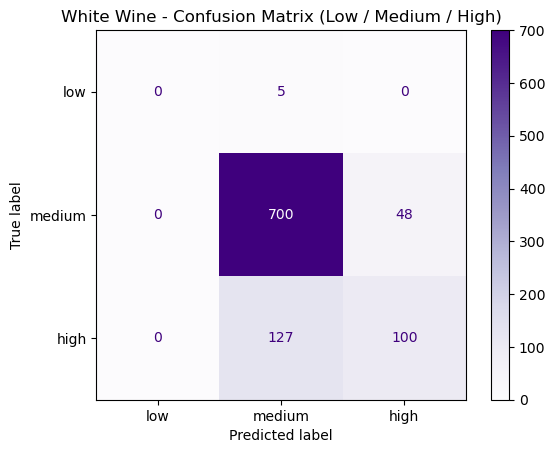

In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural network with 3 hidden layers, each with 15 nodes
mlp_model = MLPClassifier(hidden_layer_sizes=(12, 12, 12), max_iter=2000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = mlp_model.predict(X_test_scaled)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Neural Network Accuracy (3 categories, 3 layers of 15 nodes): {acc:.3f}")

# Precision, recall and F1 score (balance of the two)
labels = ["low", "medium", "high"]
precisions = precision_score(y_test, y_pred, labels=labels, average=None, zero_division=0)
recalls = recall_score(y_test, y_pred, labels=labels, average=None, zero_division=0)
f1s = f1_score(y_test, y_pred, labels=labels, average=None, zero_division=0)

for lab, p, r, f in zip(labels, precisions, recalls, f1s):
    print(f"{lab:6s}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")
    
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low", "medium", "high"])
disp.plot(cmap="Purples", values_format="d")
plt.title(f"{name} - Confusion Matrix (Low / Medium / High)")
plt.show()


Random Forest


=== Red Wine ===
Random Forest Accuracy: 0.900
low     Precision: 0.000  Recall: 0.000  F1: 0.000
medium  Precision: 0.926  Recall: 0.960  F1: 0.942
high    Precision: 0.711  Recall: 0.574  F1: 0.635


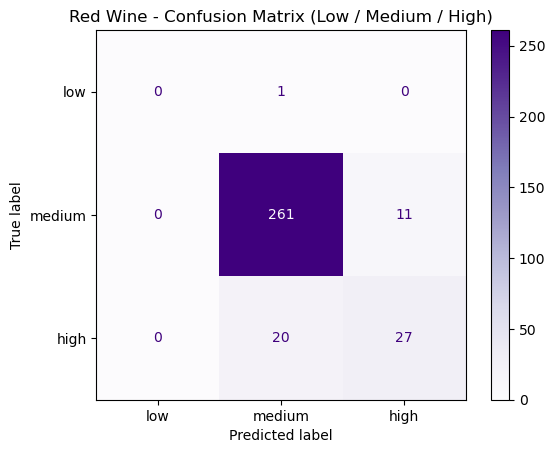


=== White Wine ===
Random Forest Accuracy: 0.886
low     Precision: 0.000  Recall: 0.000  F1: 0.000
medium  Precision: 0.895  Recall: 0.964  F1: 0.928
high    Precision: 0.845  Recall: 0.648  F1: 0.733


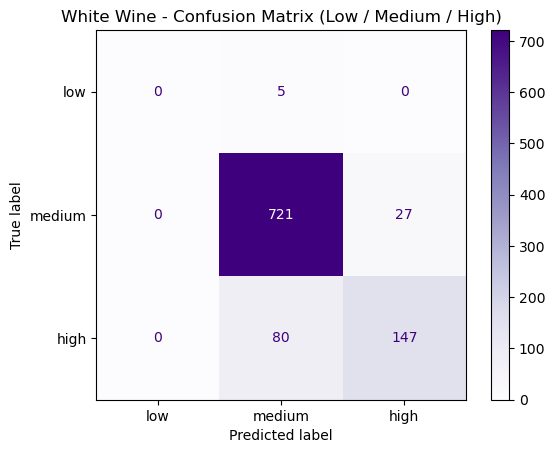

In [8]:
# Prepare datasets in a dictionary for easy looping
datasets = {
    "Red Wine": df_red,
    "White Wine": df_white
}

for name, df in datasets.items():
    print(f"\n=== {name} ===")
    
    # Separate features and labels
    X = df.drop(["quality", "quality_category"], axis=1)
    y = df["quality_category"]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Optional: Scale features (Random Forests don't require scaling, but it doesn't hurt)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test_scaled)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Random Forest Accuracy: {acc:.3f}")
    
    # Precision, recall and F1 score (balance of the two)
    labels = ["low", "medium", "high"]
    precisions = precision_score(y_test, y_pred, labels=labels, average=None, zero_division=0)
    recalls = recall_score(y_test, y_pred, labels=labels, average=None, zero_division=0)
    f1s = f1_score(y_test, y_pred, labels=labels, average=None, zero_division=0)

    for lab, p, r, f in zip(labels, precisions, recalls, f1s):
        print(f"{lab:6s}  Precision: {p:.3f}  Recall: {r:.3f}  F1: {f:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low", "medium", "high"])
    disp.plot(cmap="Purples", values_format="d")
    plt.title(f"{name} - Confusion Matrix (Low / Medium / High)")
    plt.show()

From these different models, the most effective is the Random Forest model with an accuracy score of 0.9 for red wine and 0.885 for white wine.

Hence we should use this model to predict the quality of the wine based on its features.

From here, we now need to show how quality relates to price of wine. 